# Spike Gadgets Ephys and Video Syncing

In [1]:
import os
import re
from sys import argv
from collections import defaultdict
import random
from random import randrange
import glob

In [2]:
import numpy as np
import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

## File to Numpy Array Functions from Trodes

In [4]:
# Main function
def readTrodesExtractedDataFile(filename):
    with open(filename, 'rb') as f:
        # Check if first line is start of settings block
        # TODO: Uncomment if it works
        if f.readline().decode('ascii').strip() != '<Start settings>':
#         if f.readline().strip() != '<Start settings>':

            raise Exception("Settings format not supported")
        fields = True
        fieldsText = {}
        for line in f:
            # Read through block of settings
            if(fields):
                # TODO: Uncomment if it works
                line = line.decode('ascii').strip()
#                 line = line.strip()

                # filling in fields dict
                if line != '<End settings>':
                    vals = line.split(': ')
                    fieldsText.update({vals[0].lower(): vals[1]})
                # End of settings block, signal end of fields
                else:
                    fields = False
                    dt = parseFields(fieldsText['fields'])
                    fieldsText['data'] = np.zeros([1], dtype = dt)
                    break
        # Reads rest of file at once, using dtype format generated by parseFields()
        dt = parseFields(fieldsText['fields'])
        data = np.fromfile(f, dt)
        fieldsText.update({'data': data})
        return fieldsText




In [5]:
# Parses last fields parameter (<time uint32><...>) as a single string
# Assumes it is formatted as <name number * type> or <name type>
# Returns: np.dtype
def parseFields(fieldstr):
    # Returns np.dtype from field string
    sep = re.split('\s', re.sub(r"\>\<|\>|\<", ' ', fieldstr).strip())
    # print(sep)
    typearr = []
    # Every two elmts is fieldname followed by datatype
    for i in range(0,sep.__len__(), 2):
        fieldname = sep[i]
        repeats = 1
        ftype = 'uint32'
        # Finds if a <num>* is included in datatype
        if sep[i+1].__contains__('*'):
            temptypes = re.split('\*', sep[i+1])
            # Results in the correct assignment, whether str is num*dtype or dtype*num
            ftype = temptypes[temptypes[0].isdigit()]
            repeats = int(temptypes[temptypes[1].isdigit()])
        else:
            ftype = sep[i+1]
        try:
            fieldtype = getattr(np, ftype)
        except AttributeError:
            print(ftype + " is not a valid field type.\n")
            exit(1)
        else:
            typearr.append((str(fieldname), fieldtype, repeats))
    return np.dtype(typearr)

In [6]:
def get_key_with_substring(input_dict, substring="", return_first=True):
    """
    """
    input_dict.keys()
    keys_with_substring = []
    for key in input_dict.keys():
        if substring in key:
            keys_with_substring.append(key)
    if return_first:
        return keys_with_substring[0]
    else:
        return keys_with_substring

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [7]:
protocol_name = "tethered_with_medpc"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [8]:
input_folder = "./data"

In [9]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[mM]edpc*'

- Asking the user what the path to the recording files are, with the option of using wildcards

In [10]:
raw_data_glob_pattern = input("""Type out the path(address) of the raw behavioral recording excel sheets.
Remember that if you are using a relative path, it will be based off of the location of this Jupyter Notebook.

Globbing can also be used if you want to search with a wild card(Capitalization matters). 
i.e. './data/*medpc*' will be able to find './data/mice_with_tethered_with_medpc_20220907_140232.rec'

NOTE: If left blank, the path will automatically be guessed off of the default settings 
""")

Type out the path(address) of the raw behavioral recording excel sheets.
Remember that if you are using a relative path, it will be based off of the location of this Jupyter Notebook.

Globbing can also be used if you want to search with a wild card(Capitalization matters). 
i.e. './data/*medpc*' will be able to find './data/mice_with_tethered_with_medpc_20220907_140232.rec'

NOTE: If left blank, the path will automatically be guessed off of the default settings 
./data/*medpc*


- Make this cell into non-code block if you are using the same file path for multiple runs

In [11]:
raw_data_glob_pattern = "./data/mice_with_tethered_with_medpc_20220907_140232.rec"

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [12]:
# Using the user inputted path/pattern
if raw_data_glob_pattern.strip():
    # Getting a list of all matching files
    raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
    # Checking if there were any files that matched
    if raw_data_files_list:
        raw_data_file_path = raw_data_files_list[0]
    else:
        raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

# Using the default pattern
else:
    # Searching for matching files with recursion
    if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
        raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    # Searching for matching files only in the specified folder
    elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
        raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    else:
        raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [13]:
if len(raw_data_files_list) >= 2:
    raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
else:
    # Using the first(and only file) as the file path
    raw_data_file_path = raw_data_files_list[0]

In [14]:
raw_data_file_path

'./data/mice_with_tethered_with_medpc_20220907_140232.rec'

## Extracting the data and the metadata from the Recording folder

- Creating a dictionary that has the directory as the key and a dictionary that has the file name as the key and the 

In [15]:
file_to_metadata = defaultdict(dict)

In [16]:
for item in os.listdir(raw_data_file_path):
    item_path = os.path.join(raw_data_file_path, item)
    if os.path.isdir(item_path):
        
        directory_name = os.path.basename(item_path)
        for file_name in os.listdir(item_path):
            file_path = os.path.join(item_path, file_name)
            
            
    else:
        directory_name = ""
        file_name = item
        file_path = os.path.join(raw_data_file_path, file_name)
        
        
        
        
    print(directory_name)
    print(file_name)
    try:
        trodes_recording = readTrodesExtractedDataFile(file_path)
        file_to_metadata[directory_name][file_name] = {}            
        file_to_metadata[directory_name][file_name]["file_path"] = file_path
        file_to_metadata[directory_name][file_name]["fields_text"] = trodes_recording
    except:
        print("Can not process {}".format(file_path))

20220907_140232test.spikeband
20220907_140232test.spikeband_nt12ch1.dat
20220907_140232test.DIO
20220907_140232test.dio_Controller_Din5.dat

20220907_140232test.1.mp4
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/20220907_140232test.1.mp4
20220907_140232test.raw
20220907_140232test.group0.coordinates.dat
20220907_140232test.analog
20220907_140232test.analog_Headstage_AccelZ.dat

20220907_140232test.rec
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/20220907_140232test.rec
20220907_140232test.spikes
20220907_140232test.spikes_nt22.dat

20220907_140232test.1.h264
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/20220907_140232test.1.h264
20220907_140232test.mountainsort
20220907_140232test.group0.coordinates.dat

20220907_140232test.1.trackgeometry
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/20220907_140232test.1.trackgeometry
20220907_140232test.kilosort
20220907_140232test.group0.c

/tmp/ipykernel_3620898/1163065242.py:29: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


In [17]:
raw_data_file_path

'./data/mice_with_tethered_with_medpc_20220907_140232.rec'

In [18]:
for item in os.listdir(raw_data_file_path):
    item_path = os.path.join(raw_data_file_path, item)
    if os.path.isdir(item_path):
        
        directory_name = os.path.basename(item_path)
    else:
        directory_name = "."
    directory_path = os.path.join(raw_data_file_path, directory_name)
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        if os.path.isfile(file_path):
            try:
                trodes_recording = readTrodesExtractedDataFile(file_path)
                file_to_metadata[directory_name][file_name] = {}            
                file_to_metadata[directory_name][file_name]["file_path"] = file_path
                file_to_metadata[directory_name][file_name]["fields_text"] = trodes_recording
            except:
                print("Can not process {}".format(file_path))

Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.1.mp4
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.rec
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.1.h264
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.1.trackgeometry
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.1.videoTimeStamps


/tmp/ipykernel_3620898/1163065242.py:29: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.1.mp4
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.rec
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.1.h264
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.1.trackgeometry
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.1.videoTimeStamps
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.1.mp4
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.rec
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.1.h264
Can not process ./data/mice_with_tethered_with_medpc_20220907_140232.rec/./20220907_140232test.1.trackgeometry
Can not process ./data/mice_with_tethered_with_medpc_20220907

- All the folders that were extracted from

In [19]:
file_to_metadata.keys()

dict_keys(['20220907_140232test.spikeband', '20220907_140232test.DIO', '20220907_140232test.raw', '20220907_140232test.analog', '20220907_140232test.spikes', '20220907_140232test.mountainsort', '20220907_140232test.kilosort', '20220907_140232test.stimulation', '', '20220907_140232test.LFP', '.'])

- Looking over all the extracted data

In [20]:
for key, value in file_to_metadata.items():
    print("Directory: {}".format(key))
    for file_name, trodes_dict in value.items():
        print("\tFile Name: {}".format(file_name))
        for data_type, data_value in trodes_dict["fields_text"].items():
            print("\n \t \t Trodes Data Type: {}".format(data_type))
            print("\t \t Python Type: {}".format(type(data_value)))
            print("\t \t Data Value: {}".format(data_value))

Directory: 20220907_140232test.spikeband
	File Name: 20220907_140232test.spikeband_nt12ch1.dat

 	 	 Trodes Data Type: description
	 	 Python Type: <class 'str'>
	 	 Data Value: Spike band continuous data for one channel

 	 	 Trodes Data Type: byte_order
	 	 Python Type: <class 'str'>
	 	 Data Value: little endian

 	 	 Trodes Data Type: original_file
	 	 Python Type: <class 'str'>
	 	 Data Value: 20220907_140232test.rec

 	 	 Trodes Data Type: clockrate
	 	 Python Type: <class 'str'>
	 	 Data Value: 20000

 	 	 Trodes Data Type: trodes_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 2.2.3

 	 	 Trodes Data Type: compile_date
	 	 Python Type: <class 'str'>
	 	 Data Value: Sep 16 2021

 	 	 Trodes Data Type: compile_time
	 	 Python Type: <class 'str'>
	 	 Data Value: 10:58:00

 	 	 Trodes Data Type: qt_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 5.15.1

 	 	 Trodes Data Type: commit_tag
	 	 Python Type: <class 'str'>
	 	 Data Value: heads/Release_2.2.3-0-gc9f03c90

 	

	 	 Data Value: [(-3194,) (-3188,) (-3272,) ... (-4108,) (-3793,) (-3090,)]
	File Name: 20220907_140232test.LFP_nt31ch1.dat

 	 	 Trodes Data Type: description
	 	 Python Type: <class 'str'>
	 	 Data Value: LFP data for one channel

 	 	 Trodes Data Type: byte_order
	 	 Python Type: <class 'str'>
	 	 Data Value: little endian

 	 	 Trodes Data Type: original_file
	 	 Python Type: <class 'str'>
	 	 Data Value: 20220907_140232test.rec

 	 	 Trodes Data Type: clockrate
	 	 Python Type: <class 'str'>
	 	 Data Value: 20000

 	 	 Trodes Data Type: trodes_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 2.2.3

 	 	 Trodes Data Type: compile_date
	 	 Python Type: <class 'str'>
	 	 Data Value: Sep 16 2021

 	 	 Trodes Data Type: compile_time
	 	 Python Type: <class 'str'>
	 	 Data Value: 10:58:00

 	 	 Trodes Data Type: qt_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 5.15.1

 	 	 Trodes Data Type: commit_tag
	 	 Python Type: <class 'str'>
	 	 Data Value: heads/Release_2.2.3-0-gc

## Function that gets the directory or file name based on an inputted substring

In [21]:
get_key_with_substring(file_to_metadata, substring="raw", return_first=True)

'20220907_140232test.raw'

## Looking over the ephys recording

- Getting the name of the ephys recording direcotry

In [22]:
raw_directory_name = get_key_with_substring(file_to_metadata, substring="raw", return_first=True)

In [23]:
raw_directory_name

'20220907_140232test.raw'

In [24]:
raw_directory_dict = file_to_metadata[raw_directory_name]

- Getting the name of the files in the ephys recording directory

In [25]:
raw_directory_dict.keys()

dict_keys(['20220907_140232test.group0.coordinates.dat', '20220907_140232test.timestamps.dat', '20220907_140232test.raw_group0.dat'])

In [26]:
raw_recording_file_name = get_key_with_substring(raw_directory_dict, substring="raw_group0.dat", return_first=True)

In [27]:
raw_recording_file_name

'20220907_140232test.raw_group0.dat'

In [28]:
raw_recording_fields_text = raw_directory_dict[raw_recording_file_name]["fields_text"]

In [29]:
raw_recording_fields_text

{'description': 'Raw (unfiltered) data for one sorting group',
 'byte_order': 'little endian',
 'original_file': '20220907_140232test.rec',
 'clockrate': '20000',
 'trodes_version': '2.2.3',
 'compile_date': 'Sep 16 2021',
 'compile_time': '10:58:00',
 'qt_version': '5.15.1',
 'commit_tag': 'heads/Release_2.2.3-0-gc9f03c90',
 'controller_firmware': '3.17',
 'headstage_firmware': '2.3',
 'controller_serialnum': '00104 00176',
 'headstage_serialnum': '00801 00111',
 'autosettle': '0',
 'smartref': '0',
 'gyro': '0',
 'accelerometer': '0',
 'magnetometer': '0',
 'time_offset': '0',
 'system_time_at_creation': '1662573758590',
 'timestamp_at_creation': '39059387',
 'first_timestamp': '39104773',
 'sorting_group': '0',
 'num_channels': '32',
 'voltage_scaling': '0.195',
 'fields': '<voltage 32*int16>',
 'data': array([([ -1084,   -723,   -380,   -972,   -469,  -1199,   -671,   -491,    -24,  -3433,  -2578,  -2087,   -239,    184,    814,   -516,   -970,   -770,    163,   -114,     37,  -337

- Array of Voltages for each channel

In [30]:
voltage_value_array = raw_recording_fields_text["data"]

In [31]:
voltage_value_array.shape

(6768567,)

In [32]:
voltage_value_array[:5]

array([([-1084,  -723,  -380,  -972,  -469, -1199,  -671,  -491,   -24, -3433, -2578, -2087,  -239,   184,   814,  -516,  -970,  -770,   163,  -114,    37, -3377,  -560,   -84,  -411, -3802, -3509, -3242, -2075,  -365,  -525, -1193],),
       ([-1007,  -754,  -376, -1010,  -538, -1231,  -658,  -375,   -81, -3450, -2511, -2036,  -197,   184,   798,  -430, -1001,  -790,   114,   -18,    59, -3321,  -587,  -161,  -280, -3843, -3478, -3174, -2050,  -370,  -493, -1179],),
       ([ -986,  -687,  -381, -1062,  -506, -1231,  -644,  -403,   -30, -3431, -2575, -2068,  -128,   185,   773,  -430,  -970,  -781,   -12,   -72,    47, -3259,  -635,  -206,  -241, -3756, -3493, -3180, -2116,  -361,  -554, -1129],),
       ([-1003,  -719,  -381, -1107,  -400, -1260,  -647,  -404,    17, -3392, -2626, -2089,  -261,   211,   748,  -430,  -944,  -737,    13,  -109,    15, -3216,  -571,  -115,  -367, -3800, -3463, -3239, -2116,  -462,  -511, -1098],),
       ([-1051,  -729,  -381, -1105,  -447, -1273,  -632

- Voltage Time Stamps

In [33]:
raw_directory_dict.keys()

dict_keys(['20220907_140232test.group0.coordinates.dat', '20220907_140232test.timestamps.dat', '20220907_140232test.raw_group0.dat'])

In [34]:
raw_timestamps_file_name = get_key_with_substring(raw_directory_dict, substring="timestamps.dat", return_first=True)

In [35]:
raw_timestamps_file_name

'20220907_140232test.timestamps.dat'

In [36]:
voltage_timestamp_array = raw_directory_dict[raw_timestamps_file_name]["fields_text"]["data"]

In [37]:
voltage_timestamp_array[:5]

array([(39104773,), (39104774,), (39104775,), (39104776,), (39104777,)],
      dtype=[('time', '<u4')])

In [38]:
voltage_timestamp_array.shape

(6768567,)

- Converting the array to integers to be able to do calculations

    - u4 and i2 explanation: https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/

In [39]:
voltage_timestamp_array = voltage_timestamp_array.astype(int)

In [40]:
voltage_timestamp_array[:5]

array([39104773, 39104774, 39104775, 39104776, 39104777])

In [41]:
voltage_timestamp_array[-5:]

array([45873335, 45873336, 45873337, 45873338, 45873339])

In [42]:
voltage_timestamp_array.shape

(6768567,)

## Looking over the video files

In [43]:
parent_directory_dict = file_to_metadata[""]

In [44]:
parent_directory_dict.keys()

dict_keys(['20220907_140232test.1.videoTimeStamps.cameraHWSync'])

In [45]:
video_timestamp_file_name = get_key_with_substring(parent_directory_dict, substring="videoTimeStamps", return_first=True)

In [46]:
video_time_stamp_dict = parent_directory_dict[video_timestamp_file_name]["fields_text"]

In [47]:
video_time_stamp_dict

{'clock rate': '30000',
 'fields': '<PosTimestamp uint32><HWframeCount uint32><HWTimestamp uint64>',
 'data': array([(39104810, 30742, 0), (39106160, 30743, 0), (39107726, 30744, 0),
        ..., (45870150, 35244, 0), (45871601, 35245, 0),
        (45872946, 35246, 0)],
       dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])}

In [48]:
video_time_stamp_dict["data"]

array([(39104810, 30742, 0), (39106160, 30743, 0), (39107726, 30744, 0),
       ..., (45870150, 35244, 0), (45871601, 35245, 0),
       (45872946, 35246, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [49]:
video_time_stamp_dict["data"].shape

(4505,)

# Syncing the Ephys with the Video

# From Ephys to Video

- Getting a random recording instance from ephys
    - This will be by getting a random number from 0 to the number of recording instances. This can be used as the index for the ephys recording

In [50]:
random_voltage_index = np.random.choice(voltage_timestamp_array.shape[0], 1, replace=False)  

In [51]:
random_voltage_index

array([3967628])

In [52]:
voltage_value_array[random_voltage_index]

array([([ 357,  235,  334,  352,  399,  349,  532,  469,  405,  718,  594, 1060,  421,  419,  669,  122,  400,  485,  -29,  186,   97,  384,  242,  213,  136,  171,   92,   -5,   29,  207,  191,  243],)],
      dtype=[('voltage', '<i2', (32,))])

- Getting the associated timestamp of the ephys recording

In [53]:
random_voltage_time_stamp = voltage_timestamp_array[random_voltage_index]

In [54]:
random_voltage_time_stamp

array([43072401])

- Getting the time stamps of the video frames

In [55]:
video_time_stamp_array = np.array(video_time_stamp_dict["data"])

In [56]:
video_time_stamp_array

array([(39104810, 30742, 0), (39106160, 30743, 0), (39107726, 30744, 0),
       ..., (45870150, 35244, 0), (45871601, 35245, 0),
       (45872946, 35246, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

- Getting only the first number in each tuple

In [57]:
pos_timestamp_array = np.array([x[0] for x in video_time_stamp_array]) 

In [58]:
pos_timestamp_array

array([39104810, 39106160, 39107726, ..., 45870150, 45871601, 45872946],
      dtype=uint32)

- Converting to integer to do calculations

In [59]:
pos_timestamp_array = pos_timestamp_array.astype(int)

In [60]:
pos_timestamp_array[:5]

array([39104810, 39106160, 39107726, 39108939, 39110620])

- Getting the first video time stamp that is greater than the voltage time stamp

In [61]:
current_video_time_stamp = pos_timestamp_array[pos_timestamp_array >= random_voltage_time_stamp][0]

In [62]:
current_video_time_stamp

43073477

- Where this video time stamp is(within the list of video time stamps), would be the frame number that corresponds to the ephys recording instance

In [63]:
current_video_frame = np.argwhere(pos_timestamp_array >= random_voltage_time_stamp)[0]

In [64]:
current_video_frame

array([2641])

In [65]:
current_video_frame[0]

2641

# Reading in video

In [66]:
raw_data_file_path

'./data/mice_with_tethered_with_medpc_20220907_140232.rec'

In [67]:
'./data/mice_with_tethered_with_medpc_20220907_140232.rec/20220907_140232test.'

'./data/mice_with_tethered_with_medpc_20220907_140232.rec/20220907_140232test.'

In [68]:
video_file_list = glob.glob(os.path.join(raw_data_file_path, "*.mp4"))

In [69]:
video_file_list

['./data/mice_with_tethered_with_medpc_20220907_140232.rec/20220907_140232test.1.mp4']

In [70]:
video_file_path = video_file_list[0]

In [71]:
# read video from file
cap = cv2.VideoCapture(video_file_path)

# Converting from frame to video

- Getting the number of frames per second

In [72]:
fps = cap.get(cv2.CAP_PROP_FPS)

In [73]:
fps

13.503005198137348

- Getting the time in the video that the frame corresponds to
    - Dividing the frame number by the frames per second

In [74]:
current_video_frame[0] / fps

195.58609074402997

- In minutes and seconds

In [75]:
current_video_frame[0] / fps // 60

3.0

In [76]:
current_video_frame[0] / fps % 60

15.586090744029974

## Looking over the Video

In [78]:
Video(video_file_path)

# From Video to Ephys

- Getting the total number of frames in the video

In [79]:
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

In [80]:
total_frames

4504.0

- Calculating the duration of the video
    - Dividing the total number of frames by the frames per second

In [81]:
video_duration = total_frames / fps

In [82]:
video_duration

333.5553777777778

- Getting a random number that's within the duration of the video

In [83]:
random_video_time = random.uniform(0, video_duration)

In [84]:
random_video_time

221.19156859232578

- Getting the frame number from the video time
    - Multiplying the video time by the fps

In [85]:
random_video_frame = random_video_time * fps

In [86]:
random_video_frame

2986.7509004863286

- Getting the video time stamp that's the closest to the frame

In [87]:
random_video_time_stamp = pos_timestamp_array[int(random_video_frame)]

In [88]:
random_video_time_stamp

43591669

- Getting the voltage recording instance that has the closest timestamp to the video frame's

In [89]:
voltage_timestamp_array[voltage_timestamp_array >= random_video_time_stamp][0]

43591669

In [90]:
current_voltage_index = np.argwhere(voltage_timestamp_array >= random_video_time_stamp)[0]

In [91]:
current_voltage_index

array([4486896])

In [92]:
voltage_value_array[current_voltage_index]

array([([ -856, -1344, -2719, -2575, -1427, -1247,  -654, -1166,  -521,  3069,   726,  1513,    66,  -474, -1219,  -128,  -201,  -437,  -428,  -289,  -497,  2483,  -298,  -241,  -250,  1496,  1227,  1065,   779,  -272,  -273,  -338],)],
      dtype=[('voltage', '<i2', (32,))])

# Syncing with MED-PC

In [93]:
DIO_directory_name = get_key_with_substring(file_to_metadata, substring="DIO")

In [94]:
DIO_directory_name

'20220907_140232test.DIO'

In [95]:
DIO_directory_dict = file_to_metadata[DIO_directory_name]

In [96]:
DIO_directory_dict.keys()

dict_keys(['20220907_140232test.dio_Controller_Din5.dat', '20220907_140232test.dio_ECU_Din1.dat', '20220907_140232test.dio_ECU_Dout1.dat', '20220907_140232test.dio_Controller_Din8.dat', '20220907_140232test.dio_Controller_Din7.dat', '20220907_140232test.dio_Controller_Din1.dat', '20220907_140232test.dio_ECU_Dout4.dat', '20220907_140232test.dio_ECU_Dout3.dat', '20220907_140232test.dio_Controller_Din3.dat', '20220907_140232test.dio_Controller_Din2.dat', '20220907_140232test.dio_Controller_Din6.dat', '20220907_140232test.dio_ECU_Dout2.dat', '20220907_140232test.dio_ECU_Din3.dat', '20220907_140232test.dio_ECU_Din4.dat', '20220907_140232test.dio_Controller_Din4.dat', '20220907_140232test.dio_ECU_Din2.dat'])

In [97]:
DIN_file_name = get_key_with_substring(DIO_directory_dict, substring="ECU_Din1", return_first=True)

In [98]:
DIN_file_name

'20220907_140232test.dio_ECU_Din1.dat'

In [99]:
DIN_state_array = DIO_directory_dict[DIN_file_name]["fields_text"]["data"]

In [100]:
DIN_state_array

array([(39104773, 0), (40153288, 1), (40453274, 0), (42553166, 1),
       (42853151, 0), (45253029, 1), (45553013, 0)],
      dtype=[('time', '<u4'), ('state', 'u1')])

(array([4., 0., 0., 0., 0., 0., 0., 0., 0., 3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

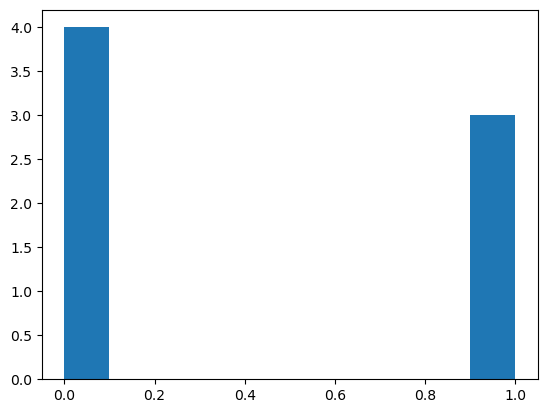

In [101]:
plt.hist([tup[1] for tup in DIN_state_array])

Text(0.5, 1.0, 'Din State Change against Timestamps')

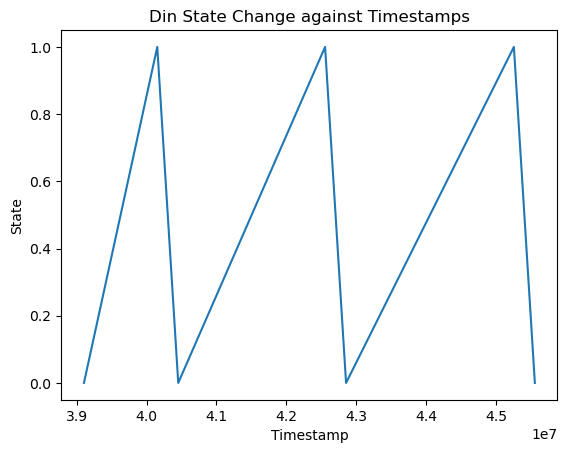

In [102]:
plt.plot([tup[0] for tup in DIN_state_array], [tup[1] for tup in DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

# From DIN to Video

- State 1 is when the MED-PC signal is being recieved. And 0 is when it is turned off. So we will get the timestamp of when it is first 1.

In [103]:
DIN_state_array

array([(39104773, 0), (40153288, 1), (40453274, 0), (42553166, 1),
       (42853151, 0), (45253029, 1), (45553013, 0)],
      dtype=[('time', '<u4'), ('state', 'u1')])

In [104]:
DIN_time_stamp = DIN_state_array[5][0]

In [105]:
DIN_time_stamp

45253029

- Getting the time stamps of the video frames

In [106]:
video_time_stamp_array = np.array(video_time_stamp_dict["data"])

In [107]:
video_time_stamp_array

array([(39104810, 30742, 0), (39106160, 30743, 0), (39107726, 30744, 0),
       ..., (45870150, 35244, 0), (45871601, 35245, 0),
       (45872946, 35246, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

- Getting only the first number in each tuple

In [108]:
pos_timestamp_array = np.array([x[0] for x in video_time_stamp_array]) 

In [109]:
pos_timestamp_array

array([39104810, 39106160, 39107726, ..., 45870150, 45871601, 45872946],
      dtype=uint32)

- Converting to integer to do calculations

In [110]:
pos_timestamp_array = pos_timestamp_array.astype(int)

- Getting the first video time stamp that is greater than the voltage time stamp

In [111]:
current_video_time_stamp = pos_timestamp_array[pos_timestamp_array >= DIN_time_stamp][0]

In [112]:
current_video_time_stamp

45253805

- Where this video time stamp is(within the list of video time stamps), would be the frame number that corresponds to the ephys recording instance

In [113]:
current_video_frame = np.argwhere(pos_timestamp_array >= current_video_time_stamp)[0]

In [114]:
current_video_frame[0]

4092

In [115]:
current_video_seconds = current_video_frame[0] / fps

In [116]:
current_video_seconds

303.0436513913558

In [117]:
print("MED-PC signal is at {}:{}".format(int(current_video_seconds // 60), int(current_video_seconds % 60)))

MED-PC signal is at 5:3


## Getting the specific frame

In [118]:
current_video_frame[0]

4092

In [119]:
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('Frame count:', frame_count)

Frame count: 4504


In [131]:
frame_number = current_video_frame[0] + 2

In [132]:
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)


True

In [133]:
_, frame = cap.read()

In [134]:
video_file_path

'./data/mice_with_tethered_with_medpc_20220907_140232.rec/20220907_140232test.1.mp4'

In [135]:
output_directory = "./proc"

In [136]:
output_directory

'./proc'

In [137]:
video_file_basename = os.path.basename(video_file_path)

In [138]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [139]:
video_file_root

'20220907_140232test.1'

In [140]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, frame_number)), frame)

True

In [141]:
raise ValueError("""Run cell after this one if you want to see the image in Jupyter Notebooks. 
Make sure that you just exit by pressing the `esc` key on the keyboard. 
DO NOT press the red X button.""")

ValueError: Run cell after this one if you want to see the image in Jupyter Notebooks. 
Make sure that you just exit by pressing the `esc` key on the keyboard. 
DO NOT press the red X button.

In [ ]:


cv2.imshow('led_light_on', frame)
cv2.waitKey(0)
cv2.destroyAllWindows()